# 0. Introudction

30 participants performed activities of daily living while carrying a waist-mounted smartphone. The phone was configured to record two implemented sensors (accelerometer and gyroscope). For these time series the directors of the underlying study performed feature generation and generated the dataset by moving a fixed-width window of 2.56s over the series. Since the windows had 50% overlap the resulting points are equally spaced (1.28s).

## 1.Data Importing and Management

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


def get_new_features(df):
    features_dup=pd.DataFrame(df.groupby('column_names').cumcount(),columns=['cumulated_count'])
    features_dup=features_dup.reset_index()
    #two data frames are merged bascially on the 'index'
    new_data=pd.merge(df.reset_index(),features_dup,how='outer')
    #attach the cumulated count to the duplicate entires
    new_data['column_names']=new_data[['column_names','cumulated_count']].apply(lambda x:\
                                                       x[0]+'_'+str(x[1]) if x[1]>0 else x[0],axis=1)
    #drop the unnecessray input featurs
    new_data=new_data.drop(['index','column_index','cumulated_count'],axis=1)
    assert all(new_data.column_names.value_counts()==1),'duplicate names are not permitted!'
    new_data=new_data.column_names.values.tolist()
    return new_data

In [35]:
def get_data(feature_dir):
    features=get_new_features(feature_dir)
    #import train and test data
    X_train=pd.read_csv(r'C:\Users\user\Desktop\data\UCI HAR Dataset\UCI HAR Dataset\train\X_train.txt'\
                       ,sep='\s+',header=None,names=features)
    X_test=pd.read_csv(r'C:\Users\user\Desktop\data\UCI HAR Dataset\UCI HAR Dataset\test\X_test.txt'\
                      ,sep='\s+',header=None,names=features)
    y_train=pd.read_csv(r'C:\Users\user\Desktop\data\UCI HAR Dataset\UCI HAR Dataset\train\y_train.txt'\
                       ,sep='\s+',header=None,names=['output'])
    y_test=pd.read_csv(r'C:\Users\user\Desktop\data\UCI HAR Dataset\UCI HAR Dataset\test\y_test.txt'\
                      ,sep='\s+',header=None,names=['output'])
    return X_train,X_test,y_train,y_test


In [37]:
features_dup_df=pd.read_csv(r'C:\Users\user\Desktop\data\UCI HAR Dataset\UCI HAR Dataset\features.txt',header=None,names=['column_index','column_names'],sep='\s+')
X_train,X_test,y_train,y_test=get_data(features_dup_df)

In [ ]:
print(f'X_train.shape:{X_train.shape}')
print(f'y_train.shape:{y_train.shape}')
print(f'X_test.shape:{X_test.shape}')
print(f'y_test.shape:{y_test.shape}')

In [ ]:
#Now,we carete two separate variables whose values are converted into the proper labels.
def labels(x):
    if x==1:
        x='WALKING'
    elif x==2:
        x='WALKING_UPSTAIRS'
    elif x==3:
        x='WALKING_DOWNSTAIRS'
    elif x==4:
        x='SITTING'
    elif x==5:
        x='STANDING'
    else:
        x='LAYING'
    return x
        
y_train_labels=y_train.output.map(lambda x: labels(x))
y_test_labels=y_test.output.map(lambda x:labels(x))

## 2.Data Visualization


 ### 2.1 Data Features and Numer Counts

![image](https://user-images.githubusercontent.com/53164959/80816015-b0fa2800-8c09-11ea-9172-fc67d678ba7b.png)


The number of observations is not stable across the five activities with those of static motions recorded at a relatively higher number. We could reasonably preassume that all the participants in these experiments were asked first to lay down and then stand. The following actions such as sitting or/and walking would be variably assigned to each of them. 

Assuming that the parcipaants had to walk the same number of starits upwards as well as downwards and knowing 
the smartphones had as constant sampling rate, the number of data points for the activites have rougly the same number with some possiblity of flawed data.


### 2.2 Distribution of The Activities

![image](https://user-images.githubusercontent.com/53164959/80810604-30362e80-8bff-11ea-9812-c9625053b766.png)
![image](https://user-images.githubusercontent.com/53164959/80812511-15fe4f80-8c03-11ea-9e68-2f747ecee494.png)


![image](https://user-images.githubusercontent.com/53164959/80811242-7213a480-8c00-11ea-8f70-5039e08534aa.png)

![image](https://user-images.githubusercontent.com/53164959/80812735-8016f480-8c03-11ea-97f2-6bfc311d5485.png)




The paper suggested that all the activities are recorded in proper units and changed in scale between -1 and 1 after the Fourier Transform is done. The massive number of input features are in the list but in this section, only two features measured by two censors are presented in our data visualization. 

Either way of the recordings and selected input features, the dynamic motions tend to be spread further out in every axis of measurement while the clusters of the static movements are densely around -1 and -0.9 in the three dimensions. Overall, the variability of active movements tends to be much larger in any feature dimensions that that of static ones.

## 2.3 Walking Duration 

From the data respository called kaggle,we can import the exacalty same data execpt for the additional column feature on pariticipants. The input feature is cateogrical data and sums up to 21 participants. Even though it is not explicitly stated that they were required to walk up and down the same number of staricases, we see no trouble assumming that they did. Let us investigate thier activity conditions. 

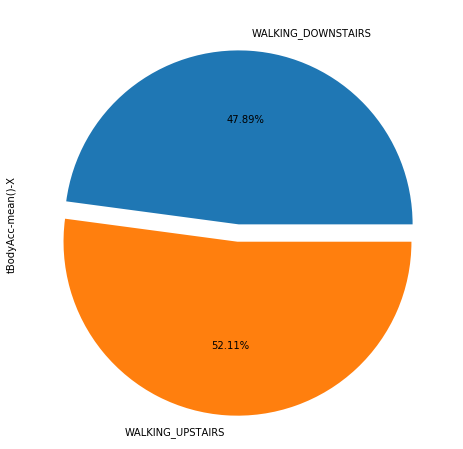

In [9]:
#import the data from kaggle
train_data=pd.read_csv(r'C:\Users\user\Downloads\train.csv\train.csv')
active_cols=train_data['Activity'].isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration_df1=train_data[active_cols].groupby(['Activity'])['tBodyAcc-mean()-X'].count()*1.28

fig,ax=plt.subplots(figsize=(10,8))
duration_df1.plot.pie(ax=ax,autopct='%.2f%%',explode=[0,0.1])

In [10]:
duration_df=train_data[active_cols].groupby(['Activity','subject'])['tBodyAcc-mean()-X'].count()*1.28
duration_df=duration_df.reset_index()

![image](https://user-images.githubusercontent.com/53164959/80856897-dbd79100-8c88-11ea-9f4c-17f1d0d26827.png)


Nearly all participants have more data for walking upstairs than downstairs. Assuming an equal number of up- and down-walks the participants need longer walking upstairs.
Furthermore the range of the duration is narrow and adjusted to the conditions. A young person being ~50% fast in walking upstairs than an older one is reasonable.

## 3 Dimensionality Reduction

### 3.1 PCA

From the previous steps, we have already seen that the number of features amounts to 561 and many of them are closely realted to each others. The overfitting problems seems to be inevitable in our data set. Among many options to reduce our dimenions, we could take feature extraction a proecss of creating new features by projecting data in the high dimensions to a space of lower dimension. This approach can help us retrieve non-redunt and relevant features. The most widely used alogirthm is PCA and we will start to find the new combinations of features with it.   

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [48]:
#standardize the data 
stn=StandardScaler()
scaled_train=stn.fit_transform(X_train)
scaled_test=stn.fit_transform(X_test)

In [147]:
pca=PCA(n_components=100)
pca.fit(scaled_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 1.0, 'The ratio of variation across the 10 components')

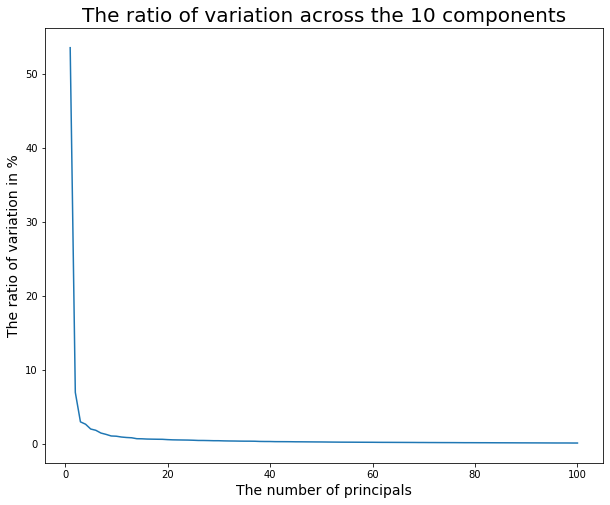

In [149]:
explnation=pca.explained_variance_/pca.explained_variance_.sum()*100
x_labels=np.arange(1,101)
fig,ax=plt.subplots(1,1,figsize=(10,8))
ax.plot(x_labels,explantion)
ax.set_xlabel('The number of principals',size=14)
ax.set_ylabel('The ratio of variation in %',size=14)
ax.set_title('The ratio of variation across the 10 components',size=20)



In [150]:
trans_data=pca.fit_transform(scaled_train)
trans_data=trans_data[:,:2]
trans_data=pd.DataFrame(trans_data,columns=['PC1','PC2'])
trans_data['Activity']=y_train_labels

![image](https://user-images.githubusercontent.com/53164959/80823684-09d0bd00-8c18-11ea-9f95-12719a6f4b03.png)

The first two principal components lead to explaining almost 90 % of the total variability. We can without any difficulty observe that there is a huge drop in the proportion of variability explained between principal
components 1 and 2, which tells us that the first two and drop the rest to find the meaningful relationship from the data. However, the last picture shows the clusters are not separable well under these newly created dimensions with some of the groups being overlapped to each other.Failure to find the separation from the static movements sounds reasonable and logical in that these three activities,we have already seen in the previous sections, demonstrates they are conglomerated around the area, which gives us some thought they are not quite indistinguishable. 

Still,we may have a good guess that the data should not be linearly separable. This motivates me to tray out the further approach for separation before moving to the next section.

### 3.2 Kernel PCA


In [16]:
from sklearn.decomposition import KernelPCA

In [17]:
kpca=KernelPCA(n_components=2)

In [57]:
trans_train=kpca.fit_transform(scaled_train)
trans_test=kpca.fit_transform(scaled_test)

In [62]:
trans_train=pd.DataFrame(trans_train,columns=['pca1','pca2'])
trans_train_data=pd.concat([trans_train,y_train_labels],axis=1)

trans_test=pd.DataFrame(trans_test,columns=['pca1','pca2'])
trans_test_data=pd.concat([trans_test,y_test_labels],axis=1)

![image](https://user-images.githubusercontent.com/53164959/80854970-85158b80-8c77-11ea-91e4-4a1f14b1f430.png)


# 4.  Modeling 
## 4.1 Random Forest

In [11]:
params={
  'n_estimators':np.arange(10,30,4),
   'max_depth':np.arange(6,12,2),
   'min_samples_leaf':np.arange(5,15,2),
    'min_samples_split':np.arange(2,10,3)
}

start=time.time()
rf=RandomForestClassifier(random_state=0,n_jobs=1)
rf_gs=GridSearchCV(rf,param_grid=params,cv=4,n_jobs=8)
#based on the estimators obtained from the graid serach, we implement the randomforest model.
rf_gs.fit(X_train,y_train)
pred=rf_gs.predict(X_test)
time_rf=time.time()-start
print(f'accuracy score:{accuracy_score(pred,y_test)}')
print(f'time_taken:{time_rf} ')

In [21]:

%matplotlib inline

rf_gs.best_params_

# rf_import_values=rf_gs
rf_import_pd=pd.DataFrame(rf_import_values,index=X_train.columns,columns=['value'])
rf_import_top=rf_import_pd.sort_values(by='value',ascending=False)[:30]
plt.figure(figsize=(8,6))
plt.title('Feature importance 30')
sns.barplot(x=rf_import_top.value,y=rf_import_top.index)
plt.show()

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


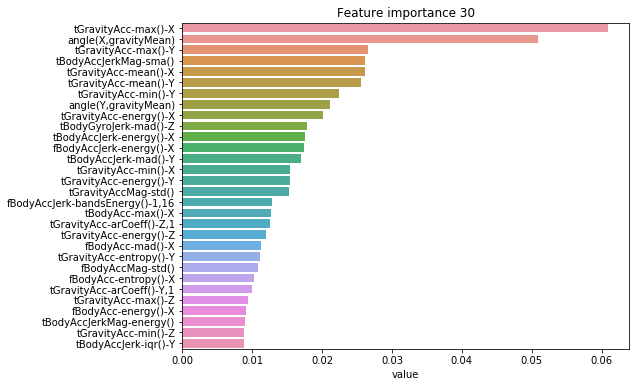

In [175]:
rf=RandomForestClassifier(max_depth=10,min_samples_leaf=13,min_samples_split=2,n_estimators=26)
rf_fit=rf.fit(X_train,y_train)
rf_import_values=rf_fit.feature_importances_
rf_import_pd=pd.DataFrame(rf_import_values,index=X_train.columns,columns=['value'])
rf_import_top=rf_import_pd.sort_values(by='value',ascending=False)[:30]
plt.figure(figsize=(8,6))
plt.title('Feature importance 30')
sns.barplot(x=rf_import_top.value,y=rf_import_top.index)
plt.show()

In [176]:
pred=rf.predict(X_test)
print(confusion_matrix(pred,y_test))
print('\n')
#Accuracy Score besed on the data
print(classification_report(pred,y_test))

[[475  48  27   0   0   0]
 [ 11 417  39   0   1   0]
 [ 10   6 354   0   0   0]
 [  0   0   0 426  41   1]
 [  0   0   0  65 490   0]
 [  0   0   0   0   0 536]]


              precision    recall  f1-score   support

           1       0.96      0.86      0.91       550
           2       0.89      0.89      0.89       468
           3       0.84      0.96      0.90       370
           4       0.87      0.91      0.89       468
           5       0.92      0.88      0.90       555
           6       1.00      1.00      1.00       536

    accuracy                           0.92      2947
   macro avg       0.91      0.92      0.91      2947
weighted avg       0.92      0.92      0.92      2947



## 4.2 XGboost

In [157]:
print("Finding Feature Importances\n")
acc=0.0
for md in range(7,101,5):
    for ne in range(150,2001,200):
        f_model=XGBClassifier(max_depth=md,n_estimators=ne,n_jobs=3,verbosity=2,min_child_weight=1,subsample=1,random_state=0,tree_method='gpu_hist')
        f_model.fit(X_train,y_train)
        pred=f_model.predict(X_test)
        acc=accuracy_score(pred,y_test,normalize=True)*100
        print(f'md:{md},ne:{ne},Accuracy={acc}')
    if acc>93.95:
        break


In [177]:
f_model=XGBClassifier(max_depth=7,n_estimators=1350,n_jobs=3,verbosity=2,min_child_weight=1,subsample=1,random_state=0)
f_model.fit(X_train,y_train)
pred=f_model.predict(X_test)


C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[22:16:17] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[22:16:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[22:16:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[22:16:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[22:16:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[22:16:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:16:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[22:16:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[22:16:18] INFO: src/tree/updater_prune.cc:74: tree pruni

KeyboardInterrupt: 

[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning en

KeyboardInterrupt: 

[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:17:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:17:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[22:17:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[22:17:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[22:17:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:17:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:17:23] INFO: src/tree/updater_prune.cc:74: tree pruning en

KeyboardInterrupt: 

[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4


KeyboardInterrupt: 

[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1


KeyboardInterrupt: 

[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2


KeyboardInterrupt: 

[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1


KeyboardInterrupt: 

[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[22:17:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0


KeyboardInterrupt: 

In [169]:
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

[[487   3   6   0   0   0]
 [ 34 432   5   0   0   0]
 [  8  26 386   0   0   0]
 [  0   3   0 419  69   0]
 [  0   0   0  29 503   0]
 [  0   0   0   0   0 537]]


              precision    recall  f1-score   support

           1       0.92      0.98      0.95       496
           2       0.93      0.92      0.92       471
           3       0.97      0.92      0.94       420
           4       0.94      0.85      0.89       491
           5       0.88      0.95      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



# 4.3 Support Vector Machine

In [31]:
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [178]:
svm_model=GridSearchCV(SVC(),param_grid=param_grid)
svm_model.fit(X_train,y_train)

In [179]:
print(f'Best Score for training data: {svm_model.best_score_*100}\n')
print(f'Best C: {svm_model.best_estimator_.C}\n')
print(f'Best Kernel:{svm_model.best_estimator_.kernel}\n')
print(f'BEst Gamma:{svm_model.best_estimator_.gamma}\n')

pred=svm_model.best_estimator_.predict(X_test)

In [45]:
#Constructing the confusion matrix
print(confusion_matrix(pred,y_test))
print('\n')
print(classification_report(y_test,pred))

[[492  24   5   0   0   0]
 [  1 447   9   2   0   0]
 [  3   0 406   0   0   0]
 [  0   0   0 436  15   0]
 [  0   0   0  53 517   0]
 [  0   0   0   0   0 537]]


              precision    recall  f1-score   support

           1       0.94      0.99      0.97       496
           2       0.97      0.95      0.96       471
           3       0.99      0.97      0.98       420
           4       0.97      0.89      0.93       491
           5       0.91      0.97      0.94       532
           6       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



## 5. Recurrent Neural Network

### 5.1 Data Importing and Management

Here,instead of making use of the whole input dadta, we involve the only three main singal types in the raw dataset:total_acc,body_acc,and
body_gyro. The signals are stored under the direcotry 'Inertial Signals' directory. Each has 3 axies of data. This implies that there are a total of nine variables for each time step.

First, we define a function called load_file and this loads a dataset and return it as a NumPy array

In [6]:
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
import os
import sys

In [7]:
def load_file(filepath):
    dataframe =pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values


In [8]:
def load_group(filenames,prefix=''):
    loaded=list()
    for name in filenames:
        s=os.path.join(prefix,name)
        data=load_file(s)
        loaded.append(data)
    #stack the group in the depthwise so that features are the 3rd dimenions
    loaded=np.dstack(loaded)
    return loaded
prefix=r'C:\Users\user\Desktop\data\UCI HAR Dataset\UCI HAR Dataset'
filenames=['total_acc_x_'+'train'+'.txt', 'total_acc_y_'+'train'+'.txt', 'total_acc_z_'+'train'+'.txt']
filepath=os.path.join(prefix,'train','Inertial Signals')

We can load all data for a given group into a single three dimensional Numpy array,where the dimensions of the array are [samples,timestpes,features]. To be it clearer, there are 128 time steps and nine features wehre the number of samples is the number of rows in any given raw signal data file.

In [9]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):   
    filepath = os.path.join(prefix,group,'Inertial Signals')
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X=load_group(filenames,filepath)
    # load class output
    y_file_path=os.path.join(prefix,group)
    y = load_file(y_file_path+ '\y_'+group+'.txt')
    return  X,y


Finally,we can load each of the train and test datasets. 

The output,y is now currently defined as an integer for the class number. We must one hot enode these class integers so that the data
is suitable for fitting a neural network multi classification model. 

In [10]:
# trainX,trainy=load_dataset_group('train',prefix=r'C:\Users\user\Desktop\data\UCI HAR Dataset\UCI HAR Dataset')
def load_dataset(prefix=''):
    #load all train
    trainX,trainy=load_dataset_group('train',prefix)
    #laod all the test
    testX,testy=load_dataset_group('test',prefix)
    #Zero-offset class Values(ie making the range of lables start from zero)
    trainy-=1
    testy-=1
    #one-hot encode y
    trainy=to_categorical(trainy)
    testy=to_categorical(testy)
    print(trainX.shape,trainy.shape,testX.shape,trainy.shape)
    return trainX,trainy,testX,testy
    
    

In [11]:
trainX,trainy,testX,testy=load_dataset(prefix=r'C:\Users\user\Desktop\data\UCI HAR Dataset\UCI HAR Dataset')

(7352, 128, 9) (7352, 6) (2947, 128, 9) (7352, 6)


### 5.2 LSTM Modeling

Before modeling our recurrent modeling,we need set up the parameters including the time steps,batch sizes and so on. 

- The number of steps : 128 
- The number of features inovled in the expriements : 9
- The number of output : 6

Additionally,we need to determine the size of batch, 64. The iteration will continue for 64 times to make sure that model is being trainined properly. To make it simple, we will define the mode as having the only single layer followed by a dropout layer to reduce the overfitting of the model to the trainig set. Finally, a fully connected layer


In [12]:
def evaluate_model(trainX,trainy,testX,testy):
    verbose,EPOCHS,batch_size=0,15,64
    n_timesteps,n_features,n_ouputs=trainX.shape[1],trainX.shape[2],trainy.shape[1]
    model=Sequential()
    model.add(LSTM(100,input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(n_ouputs,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optim='adam',metrics=['accuracy'])
    #fit networks
    model.fit(trainX,trainy,epochs=EPOCHS,batch_size=batch_size,verbose=verbose)
    _,accuracy=model.evaluate(testX,testy,batch_size=batch_size,verbose=0)
    return accuracy

In [13]:
scores=list()
for r in range(10):
    score=evaluate_model(trainX,trainy,testX,testy)
    score=score*100
    print('>#%d %.3f' %(r+1,score))
    print(f'accuracy:{np.round(score,3)}')
    scores.append(score)
    

>#1 91.890
accuracy:91.89
>#2 91.313
accuracy:91.313
>#3 91.856
accuracy:91.856
>#4 89.650
accuracy:89.65
>#5 90.872
accuracy:90.872
>#6 91.720
accuracy:91.72
>#7 91.653
accuracy:91.653
>#8 89.583
accuracy:89.583
>#9 90.431
accuracy:90.431
>#10 91.279
accuracy:91.279


### 5.3 LSTM performance meaures

We can now summarize the samples of scores by computing the average and standard deviation of the performance. The mean is telling us the average score of the perfomance of our training model wheareas the standard deviatiion gives the average variance of accuracy from the mean. 


In [22]:
print(np.round(scores,3))
mean_scores,sd_scores=np.mean(scores),np.std(scores)
print(f'Accuracy: {np.round(mean_scores,3)}+/-{np.round(sd_scores,3)} %')

[91.89  91.313 91.856 89.65  90.872 91.72  91.653 89.583 90.431 91.279]
Accuracy: 91.025+/-0.825 %


The accuracy scores turns out to be no better than  that of the previous two models. This is still showing an impressive score since the original papper shows that its result on average was 89% with the model being trained on the dataset with heavy domain-specific engineering, not the raw one.